In [1]:
import numpy as np
import keras
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
import time
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import holidays
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/shivanikohli/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = pd.read_excel('GEFcom2014Data/GEFCom2014-E.xlsx', skiprows =range(1,17545))

In [3]:
data['month'] = np.cos(2*np.pi*data.Date.dt.month / 12)
data['dow'] = np.cos(2*np.pi*data.Date.dt.dayofweek / 7)
data['hour'] = np.cos(2*np.pi*data.Date.dt.hour/24)
us_holiday = holidays.US()
data['is_holiday'] = 1 * data.Date.dt.date.apply(lambda x: x in us_holiday)
data.drop(['Date', 'Hour'],1, inplace=True)
c = list(data.columns)
c = c[1:] + c[:1]
data = data[c]
c = list(data.columns)
c = c[1:] + c[:1]
data = data[c]
data['CDD'] =  np.maximum(data.Temperature-65,0)
data['HDD'] = np.maximum(65 - data.Temperature,0)
scale = data.load.std()
offset = data.load.mean()
data.load = (data.load - offset) / scale

In [4]:
dataPredictors = data.drop('load', axis = 1)

In [5]:
dataTarget = data['load']

In [6]:
data.head()

,month,dow,hour,is_holiday,load,Temperature,CDD,HDD
0,0.866025,0.62349,1.0,1,-0.513969,22.666667,0.0,42.333333
1,0.866025,0.62349,1.0,1,-0.784751,20.666667,0.0,44.333333
2,0.866025,0.62349,1.0,1,-0.948599,21.333333,0.0,43.666667
3,0.866025,0.62349,1.0,1,-1.040010,19.000000,0.0,46.000000
4,0.866025,0.62349,1.0,1,-1.033111,19.333333,0.0,45.666667


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataPredictors,dataTarget, test_size=0.2, shuffle =True)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(63110, 7)
(63110,)
(15778, 7)
(15778,)


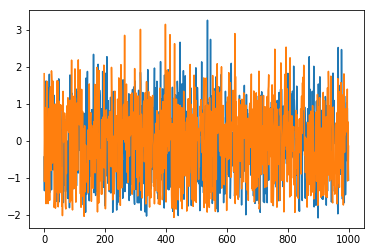

In [8]:
plt.plot(y_train[:1000])
plt.plot(y_test[:1000])

In [25]:
# train = data[:7*len(data)//8]
# test = data[7*len(data)//8:]
# nt = np.array(train)
# ntt = np.array(test)
# x_train = nt[:,:-1]
# y_train = nt[:,-1]
# x_test = np.array(test)[:,:-1]
# y_test = np.array(test)[:,-1]
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

(69027, 7)
(69027,)
(9861, 7)
(9861,)


In [9]:
def row2seq_rnn(data, yValues, history=24, future = 0):
    x = []
    xf = []
    y = []
    yf = []
    for i in np.arange(history+1, len(data)-max(future,1)):
        a = data[i-history:i+1]
        b= yValues[i-history-1:i].reshape(-1,1)
        x.append(np.append(a, b, axis=1))
        xf.append(data[i+1:i+future+1])
        y.append(yValues[i])
        yf.append(yValues[i:i+future])
    return np.array(x), np.array(xf), np.array(y), np.array(yf)

In [10]:
xt, xtf, yt, ytf = row2seq_rnn(x_train, y_train, history=24, future=1)
xtt, xttf, ytt, yttf = row2seq_rnn(x_test, y_test, history=24, future=1)


In [11]:
#types, and check shouldn't round
def pinball(y_true, y_pred, step =10):
    tau = K.arange(step, 100, step, dtype=np.float32)/100
#     tau = [.2,.7]
    tau = K.reshape(tau,(1,-1))
    y_true = K.reshape(y_true,(-1,1))
    a = K.maximum(y_true - y_pred, 0) * tau
    b = K.maximum(y_pred - y_true, 0) * (1 - tau)
    pin = K.mean(a+b)
    return pin

In [12]:
layer = 3
hiddenU = 32
val_dictionary = {}
model = keras.models.Sequential(name = 'LSTM')
model.add(keras.layers.LSTM(hiddenU, input_shape = xt.shape[1:], return_sequences = layer > 1))

for i in range(layer-1):
    model.add(keras.layers.LSTM(hiddenU, return_sequences = i < layer-2))
model.add(Dense(9))

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4)
model.compile(loss= lambda y, yp: (pinball(y, yp, 10)), optimizer = 'adam')

In [48]:
# hist = model.fit(xt, yt, batch_size=768, epochs=100,validation_split=0.1, verbose=1, callbacks=[keras.callbacks.ModelCheckpoint(
# 'Weights/LSTM3LayerPredict12', save_best_only=True, save_weights_only=True)
#   , keras.callbacks.EarlyStopping(patience=20)])
# best_val = min(hist.history['val_loss'])


In [13]:
model.load_weights('Weights/LSTM3Layer')

In [14]:
predictions = []
for i in range(1):
    preds = model.predict(xtt, batch_size= 768)
    predictions.append(preds)

In [16]:
prediction = np.array(predictions)
prediction = prediction.reshape(15752,1,9)
# prediction.shape

In [15]:
target_used = yttf 
target_used.shape

(15752, 1)

In [17]:
count_list = []
pin_list = []
# bins = [-1,1,10,20,30,40,50,60,70,80,90,99,101]
bins = [-1,1,2,3,4,5,6,7,8,9,10]
for hour in range(1):
#     ts = (np.arange(1, 100,10, dtype=np.float32)/100).reshape(1,-1)
#     ts = (np.arange(1, 100, 1, dtype=np.float32)/100).reshape(1,-1)
    ts = [0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]
    for ts in ts:
        b = np.maximum(target_used[:,hour,None] - prediction[:,hour,:], 0) * (1 - ts)
        a = np.maximum(prediction[:,hour,:] - target_used[:,hour,None], 0) * ts
        pin = np.mean(a+b)
        pin_list.append(pin*scale)
    counts, bins = np.histogram((prediction[:,hour,:]>target_used[:,hour,None]).sum(1), bins=bins)
    count_list.append(counts)
    print(count_list)
    print('iteration for time %d' %hour)
    
count_array = np.array(count_list)

[array([1598, 1602, 1447, 1632, 1541, 1534, 1549, 1625, 1656, 1568])]
iteration for time 0


In [24]:
np.mean(pin_list)

247.05046403261213

In [27]:
def qcs(expected, observed):
    return ((observed-expected)**2/expected/len(expected)).sum(0)

In [28]:
n_examples = count_array.sum(1)[0]
prob_bins = np.array([0.1,0.1, 0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
for i in range(1):
    print(qcs(prob_bins*n_examples, count_array[i]))

2.1275774504824785


([<matplotlib.axis.XTick at 0x1819abfb00>,
 <a list of 12 Text xticklabel objects>)

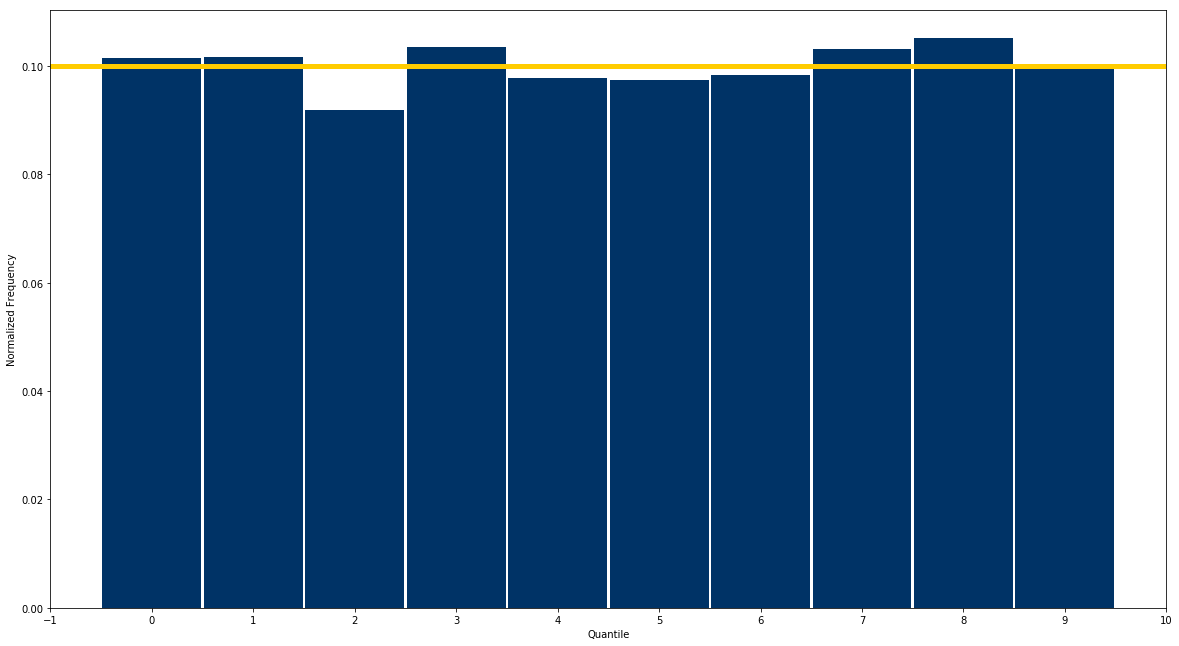

In [30]:
plt.figure(figsize=(20,11))
t = 0
plt.bar(np.arange(10), count_array.sum(0)/count_array.sum(), width=0.975, align='center', color = '#003366' )
# plt.xticks(range(10), [f'{i}% - {i+10}%' for i in range(0,110,10)])
plt.xlabel('Quantile')
plt.ylabel('Normalized Frequency')
# plt.plot((-0.6, 0.6), (0.01, 0.01), color='r', lw=3)
# plt.plot((11-0.6, 11+0.6), (0.01, 0.01), color='r', lw=3)
# plt.plot((1-0.6, 1+0.6), (0.09, 0.09), color='r', lw=3)
# plt.plot((10-0.6, 10+0.6), (0.09, 0.09), color='r', lw=3)
# plt.ylim(0,.045)
for i in range(0,10):
    plt.plot((i-0.6, i+0.6), (0.1, 0.1), color='#FFCC00', lw=3)
plt.plot((-100000, 100000), (0.1, 0.1), color='#FFCC00', lw=5)
plt.xlim(0 - 0.025/2,9.5- 0.025/2)
plt.xticks([-1,0,1,2,3,4,5,6,7,8,9,10])

In [ ]:
for layer in model.layers:
    weights = layer.get_weights()
print(weights)

In [31]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25, 32)            5248      
_________________________________________________________________
lstm_2 (LSTM)                (None, 25, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 297       
Total params: 22,185
Trainable params: 22,185
Non-trainable params: 0
_________________________________________________________________
